In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os 
import osmnx as ox
import networkx as nx

In [ ]:
import sys
from pathlib import Path

# allow imports from src/
PROJECT_ROOT = Path("...").resolve()
sys.path.append(str(PROJECT_ROOT))

# import dataloader function
from src.data.dataload import load_csv_folder_to_dataframe

DATA_DIR = PROJECT_ROOT / "data/raw"
PLOTS_DIR = PROJECT_ROOT / "outputs/plots"

In [2]:
# read csv into dataframe
df_all = pd.read_csv("df_all.csv")

In [3]:
# timestamps to datetime
df_all['iso_timestamp'] = pd.to_datetime(df_all['iso_timestamp'], utc=True, format='mixed')

# change columns to numerics
print(df_all.dtypes)
numeric_cols = [
    "channels_in", "channels_out", "channels_unknown", "channels_all", 
    "site_temperature", "site_rain_accumulation", "site_snow_accumulation"]

df_all[numeric_cols] = df_all[numeric_cols].apply(pd.to_numeric, errors='coerce')

df_all["count"] = df_all[["channels_out", "channels_in", "channels_unknown"]].fillna(0).sum(axis=1)


operator_name                          object
domain_name                            object
domain_id                               int64
counter_site                           object
counter_site_id                         int64
counter_serial                         object
longitude                             float64
latitude                              float64
timezone                               object
iso_timestamp             datetime64[ns, UTC]
channels_in                           float64
channels_out                          float64
channels_unknown                      float64
channels_all                            int64
site_temperature                      float64
site_rain_accumulation                float64
site_snow_accumulation                float64
dtype: object


In [4]:
# subset of dataframe just for one town 
df_domain = df_all[df_all["domain_name"] == "Stadt Heidelberg"] # change domain name here for other towns
df_domain = df_domain[df_domain["counter_site"] != "Schlierbacher Landstraße"] # i do not understand why this site doesn't work
df_domain = df_domain[df_domain["counter_site"] != "Ernst-Walz-Brücke West - alt"] # no overlap with many sites
title_domain = df_domain["domain_name"].iloc[0]
print(title_domain)
df_domain_grouped = df_domain.groupby("counter_site")

# get coordinates for every counter site
domain_coords = {
    name: (
        df_domain_grouped.get_group(name)["latitude"].iloc[0],
        df_domain_grouped.get_group(name)["longitude"].iloc[0]
    )
    for name in df_domain_grouped.groups.keys()
}
domain_coords

Stadt Heidelberg


{'Bahnstadtpromenade': (np.float64(49.39770881177102),
  np.float64(8.672678949737529)),
 'Berliner Straße Querschnitt': (np.float64(49.42197166293551),
  np.float64(8.677004169311507)),
 'Eppelheimer Str. Querschnitt': (np.float64(49.40470762611589),
  np.float64(8.64976028739517)),
 'Ernst-Walz-Brücke Querschnitt': (np.float64(49.40953402601704),
  np.float64(8.676711154365599)),
 'Gaisbergstraße': (np.float64(49.406723), np.float64(8.69424)),
 'Hardtstraße': (np.float64(49.3886384101731), np.float64(8.676692652778558)),
 'Kurfürstenanlage Querschnitt': (np.float64(49.40648754349749),
  np.float64(8.68846627824381)),
 'Liebermannstraße': (np.float64(49.39632740406388),
  np.float64(8.688098472233529)),
 'Mannheimer Straße': (np.float64(49.4118), np.float64(8.65914)),
 'Plöck': (np.float64(49.40913), np.float64(8.698543)),
 'Rohrbacher Straße Querschnitt': (np.float64(49.39768239906317),
  np.float64(8.689534722556413)),
 'Thedor-Heuss-Brücke Querschnitt': (np.float64(49.4117917045884

In [5]:
# we need a reference latitude for the conversion
lat0 = np.mean([coord[0] for coord in domain_coords.values()])

# function to convert lat/lon to x/y in meters
def latlon_to_xy(coord, lat0=lat0):
    lat, lon = coord
    R = 6371000 # radius of earth in meters
    x = R * np.radians(lon) * np.cos(np.radians(lat0))
    y = R * np.radians(lat)
    return np.array([x, y])

# distance matrix
sites1 = list(domain_coords.keys())
dist_matrix_euclid = pd.DataFrame(index=sites1, columns=sites1, dtype=float)

# compute euclidean distances and fill the distance matrix
for a in sites1:
    for b in sites1:
        p1 = latlon_to_xy(domain_coords[a])
        p2 = latlon_to_xy(domain_coords[b])
        dist_matrix_euclid.loc[a, b] = np.linalg.norm(p1 - p2)

dist_matrix_euclid

,Bahnstadtpromenade,Berliner Straße Querschnitt,Eppelheimer Str. Querschnitt,Ernst-Walz-Brücke Querschnitt,Gaisbergstraße,Hardtstraße,Kurfürstenanlage Querschnitt,Liebermannstraße,Mannheimer Straße,Plöck,Rohrbacher Straße Querschnitt,Thedor-Heuss-Brücke Querschnitt,Ziegelhäuser Landstraße
Bahnstadtpromenade,0.000000,2715.995405,1831.782126,1346.880384,1854.272217,1049.559112,1502.547094,1126.181474,1847.884009,2261.595620,1219.578089,2134.051878,4539.385588
Berliner Straße Querschnitt,2715.995405,0.000000,2751.497586,1383.164613,2104.795074,3706.557126,1911.078316,2962.340991,1717.525447,2113.674606,2848.952408,1604.315149,3555.257309
Eppelheimer Str. Querschnitt,1831.782126,2751.497586,0.000000,2022.492935,3226.056914,2643.851670,2807.499718,2926.236297,1040.442063,3563.691606,2981.958572,3206.336231,5746.137844
Ernst-Walz-Brücke Querschnitt,1346.880384,1383.164613,2022.492935,0.000000,1306.223348,2323.486857,915.503147,1683.850249,1296.062794,1580.249688,1611.698945,1184.977311,3724.089353
Gaisbergstraße,1854.272217,2104.795074,3226.056914,1306.223348,0.000000,2378.170163,418.568746,1238.405596,2601.598320,410.567097,1061.351679,574.285382,2685.465527
Hardtstraße,1049.559112,3706.557126,2643.851670,2323.486857,2378.170163,0.000000,2159.823238,1188.286769,2871.557041,2773.308693,1369.188905,2823.552761,4929.705270
Kurfürstenanlage Querschnitt,1502.547094,1911.078316,2807.499718,915.503147,418.568746,2159.823238,0.000000,1130.069347,2202.552154,786.067184,982.134558,665.168628,3062.301095
Liebermannstraße,1126.181474,2962.340991,2926.236297,1683.850249,1238.405596,1188.286769,1130.069347,0.000000,2711.105576,1611.729085,183.029836,1751.720878,3742.712418
Mannheimer Straße,1847.884009,1717.525447,1040.442063,1296.062794,2601.598320,2871.557041,2202.552154,2711.105576,0.000000,2866.362915,2701.965489,2429.414954,4905.593672
Plöck,2261.595620,2113.674606,3563.691606,1580.249688,410.567097,2773.308693,786.067184,1611.729085,2866.362915,0.000000,1430.080745,515.058788,2281.418024


In [6]:
# compute median of lats and lons for center point
lats = [coord[0] for coord in domain_coords.values()]
cp_lat = np.median(lats)

lons = [coord[1] for coord in domain_coords.values()]
cp_lon = np.median(lons)

# set median as center point 
center_point = (cp_lat, cp_lon)  

# access streetmaps graph with bike lanes, with median cp and x km radius (adjust if needed)
G = ox.graph_from_point(center_point, dist=6000, network_type='bike')

In [7]:
# nodes in our graph are our counter sites 
snapped_nodes = {}
for name, (lat, lon) in domain_coords.items():
    node = ox.distance.nearest_nodes(G, X=lon, Y=lat)
    snapped_nodes[name] = node

In [8]:
# now name the nodes and compute shortest distance by bike
distances1 = {}
for i in snapped_nodes:
    for j in snapped_nodes:
        if (j, i) in distances1:
            distances1[(i, j)] = distances1[(j, i)]
            continue
        if i == j:
            distances1[(i, j)] = 0
            continue
        d = nx.shortest_path_length(G, snapped_nodes[i], snapped_nodes[j], weight='length')
        distances1[(i, j)] = d
        print(f"distance between {i} and {j}: {d:.1f} m")


distance between Bahnstadtpromenade and Berliner Straße Querschnitt: 3505.2 m
distance between Bahnstadtpromenade and Eppelheimer Str. Querschnitt: 2126.5 m
distance between Bahnstadtpromenade and Ernst-Walz-Brücke Querschnitt: 1809.7 m
distance between Bahnstadtpromenade and Gaisbergstraße: 2136.7 m
distance between Bahnstadtpromenade and Hardtstraße: 1463.8 m
distance between Bahnstadtpromenade and Kurfürstenanlage Querschnitt: 1726.8 m
distance between Bahnstadtpromenade and Liebermannstraße: 1312.8 m
distance between Bahnstadtpromenade and Mannheimer Straße: 2481.6 m
distance between Bahnstadtpromenade and Plöck: 2601.4 m
distance between Bahnstadtpromenade and Rohrbacher Straße Querschnitt: 1569.8 m
distance between Bahnstadtpromenade and Thedor-Heuss-Brücke Querschnitt: 2516.8 m
distance between Bahnstadtpromenade and Ziegelhäuser Landstraße: 5201.0 m
distance between Berliner Straße Querschnitt and Eppelheimer Str. Querschnitt: 4030.9 m
distance between Berliner Straße Querschni

In [9]:
# compute all the routes as well and store them in a dict
# you can plot it too! (uncomment last line, do not recommend it for stuttgart though)
routes = {}

keys = list(snapped_nodes.keys())

for i in keys:
    for j in keys:
        if (j, i) in routes:
            routes[(i, j)] = routes[(j, i)]
            continue
        if i == j:
            routes[(i, j)] = [snapped_nodes[i]]
            continue
        r = nx.shortest_path(G, snapped_nodes[i], snapped_nodes[j], weight='length')
        routes[(i, j)] = r
        #ox.plot_graph_route(G, r)



- Heidelberg: 15 counter
- Stuttgart: 15 counter
- Ludwigsburg: 15 counter
- Mannheim: 14 counter
- Freiburg: 10 counter
- Reutlingen: 7 counter
- Konstanz: 6 counter
- Tübingen: 5 counter
- Heilbronn: 4 counter
- Lörrach: 2 counter


In [10]:
# pivot table for correlation matrix
df_domain_pivot = df_domain.pivot_table(
    index = 'iso_timestamp',
    columns = 'counter_site',
    values = 'count',
    aggfunc='sum'
)

# we want to see how many timestamps have data for both sites
mask = df_domain_pivot.notna().astype(int)
overlap = mask.T.dot(mask)
overlap

counter_site,Bahnstadtpromenade,Berliner Straße Querschnitt,Eppelheimer Str. Querschnitt,Ernst-Walz-Brücke Querschnitt,Gaisbergstraße,Hardtstraße,Kurfürstenanlage Querschnitt,Liebermannstraße,Mannheimer Straße,Plöck,Rohrbacher Straße Querschnitt,Thedor-Heuss-Brücke Querschnitt,Ziegelhäuser Landstraße
counter_site,,,,,,,,,,,,,
Bahnstadtpromenade,30350,29848,30346,30350,25720,29788,30327,30216,30349,22807,30349,30350,22469
Berliner Straße Querschnitt,29848,46351,46236,46351,37659,39752,44901,44791,46350,39294,46350,46351,25070
Eppelheimer Str. Querschnitt,30346,46236,48073,48073,39377,39758,45409,46513,48072,40530,48072,48072,25567
Ernst-Walz-Brücke Querschnitt,30350,46351,48073,99918,78779,39758,54159,60182,87503,79961,61741,64056,34325
Gaisbergstraße,25720,37659,39377,78779,78779,31062,45463,51591,78778,71236,53017,55332,27966
Hardtstraße,29788,39752,39758,39758,31062,39796,39757,38198,39757,32716,39757,39776,25049
Kurfürstenanlage Querschnitt,30327,44901,45409,54159,45463,39757,54159,52600,54158,46616,54159,54158,34311
Liebermannstraße,30216,44791,46513,60182,51591,38198,52600,60182,60181,52639,60182,60181,34193
Mannheimer Straße,30349,46350,48072,87503,78778,39757,54158,60181,87503,79960,61740,64055,34324


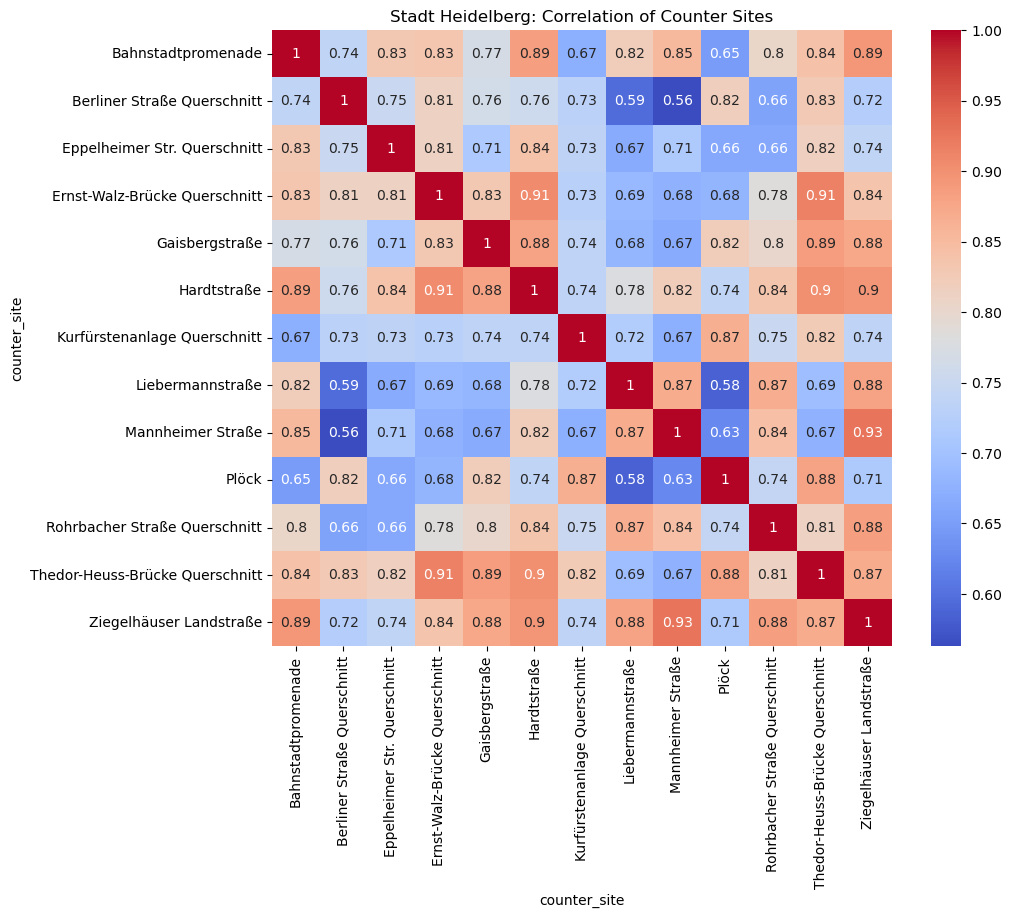

In [11]:
# compute correlation matrix and plot heatmap
# this shows correlation of counter sites based on their counts
corr_matrix = df_domain_pivot.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title(f"{title_domain}: Correlation of Counter Sites")
plt.show()

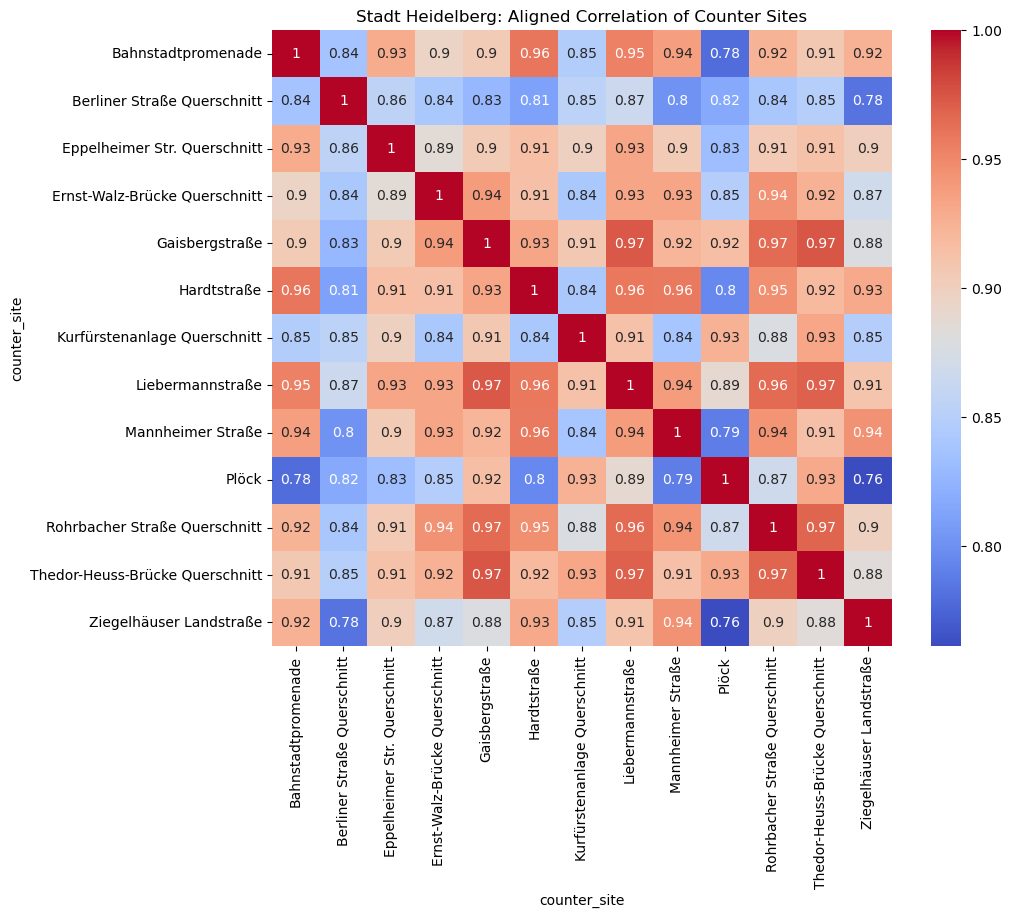

In [12]:
# correlation matrix for just times where all sites have data
# maybe more meaningful, still not sure
aligned = df_domain_pivot.dropna()
corr_matrix1 = aligned.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix1, annot=True, cmap='coolwarm')
plt.title(f"{title_domain}: Aligned Correlation of Counter Sites")
plt.show()

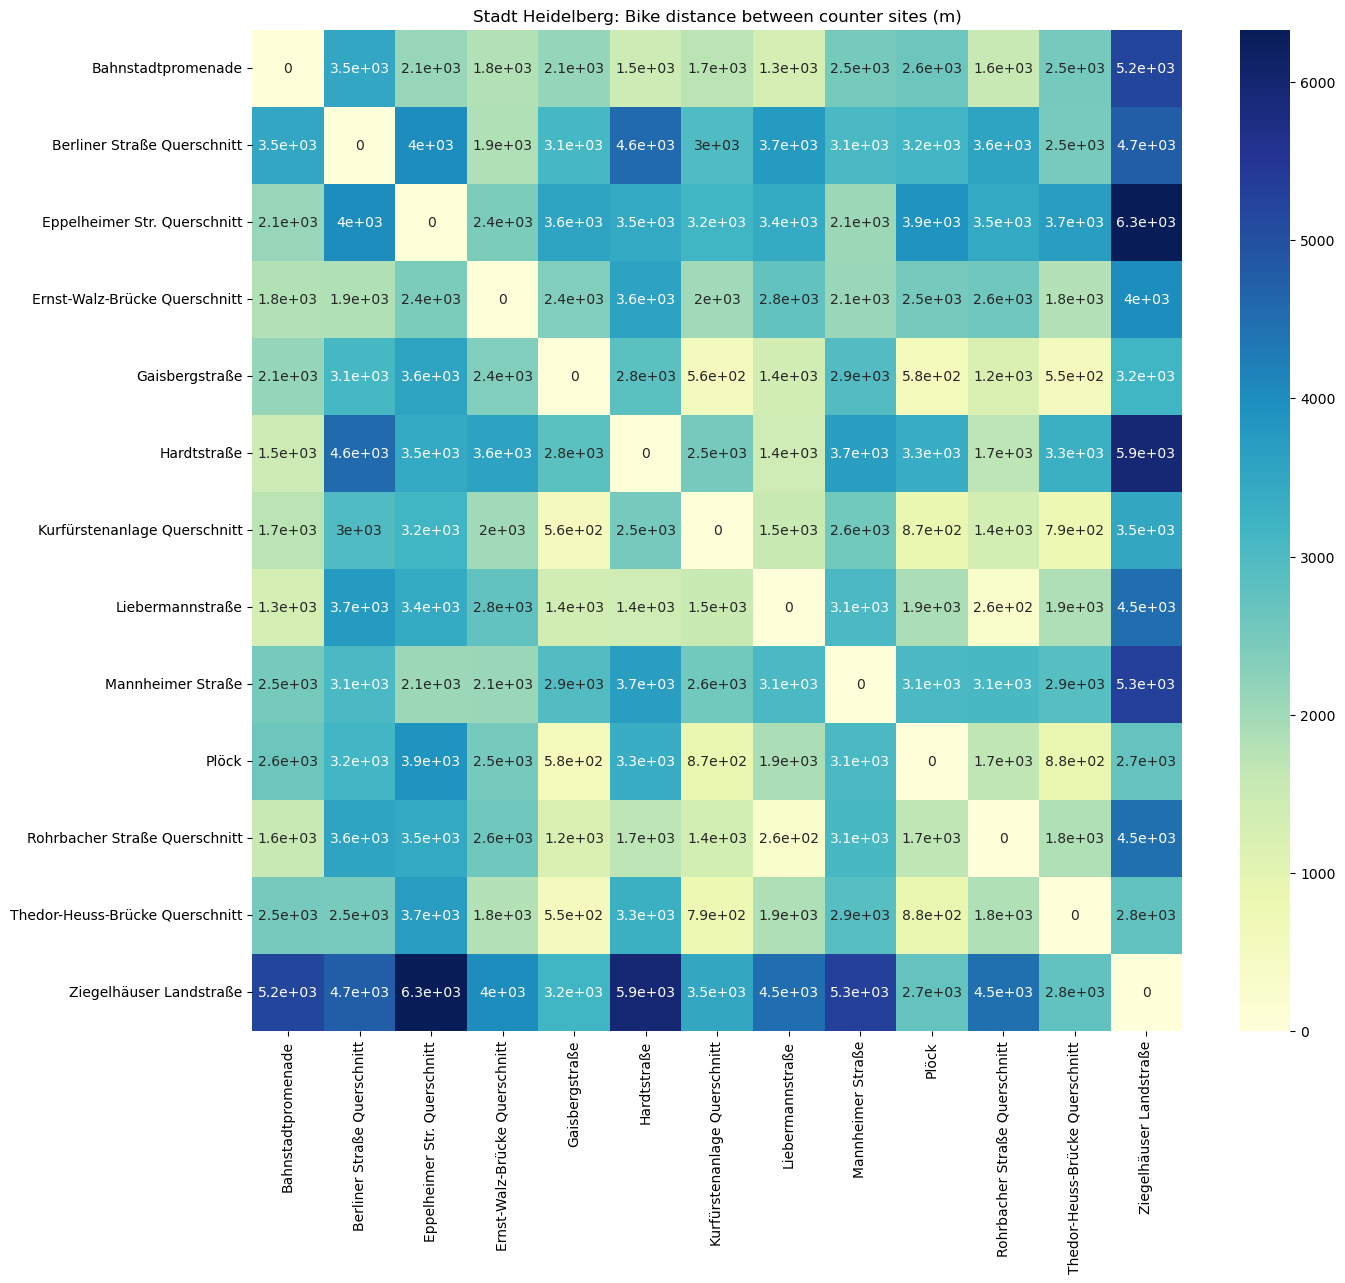

In [13]:
# now we want matrices for distances
# create distance matrix (for bike dist)
dist_matrix = pd.DataFrame(index=sites1, columns=sites1)
for (site1, site2), dist in distances1.items():
    dist_matrix.loc[site1, site2] = dist
    dist_matrix.loc[site2, site1] = dist

# fill diagonal with 0
dist_matrix.fillna(0, inplace=True)

# check shape
dist_matrix.shape

# heatmap for distances 
plt.figure(figsize=(15,13))
sns.heatmap(dist_matrix.astype(int), annot=True, cmap='YlGnBu')
plt.title(f"{title_domain}: Bike distance between counter sites (m)")
plt.show()  

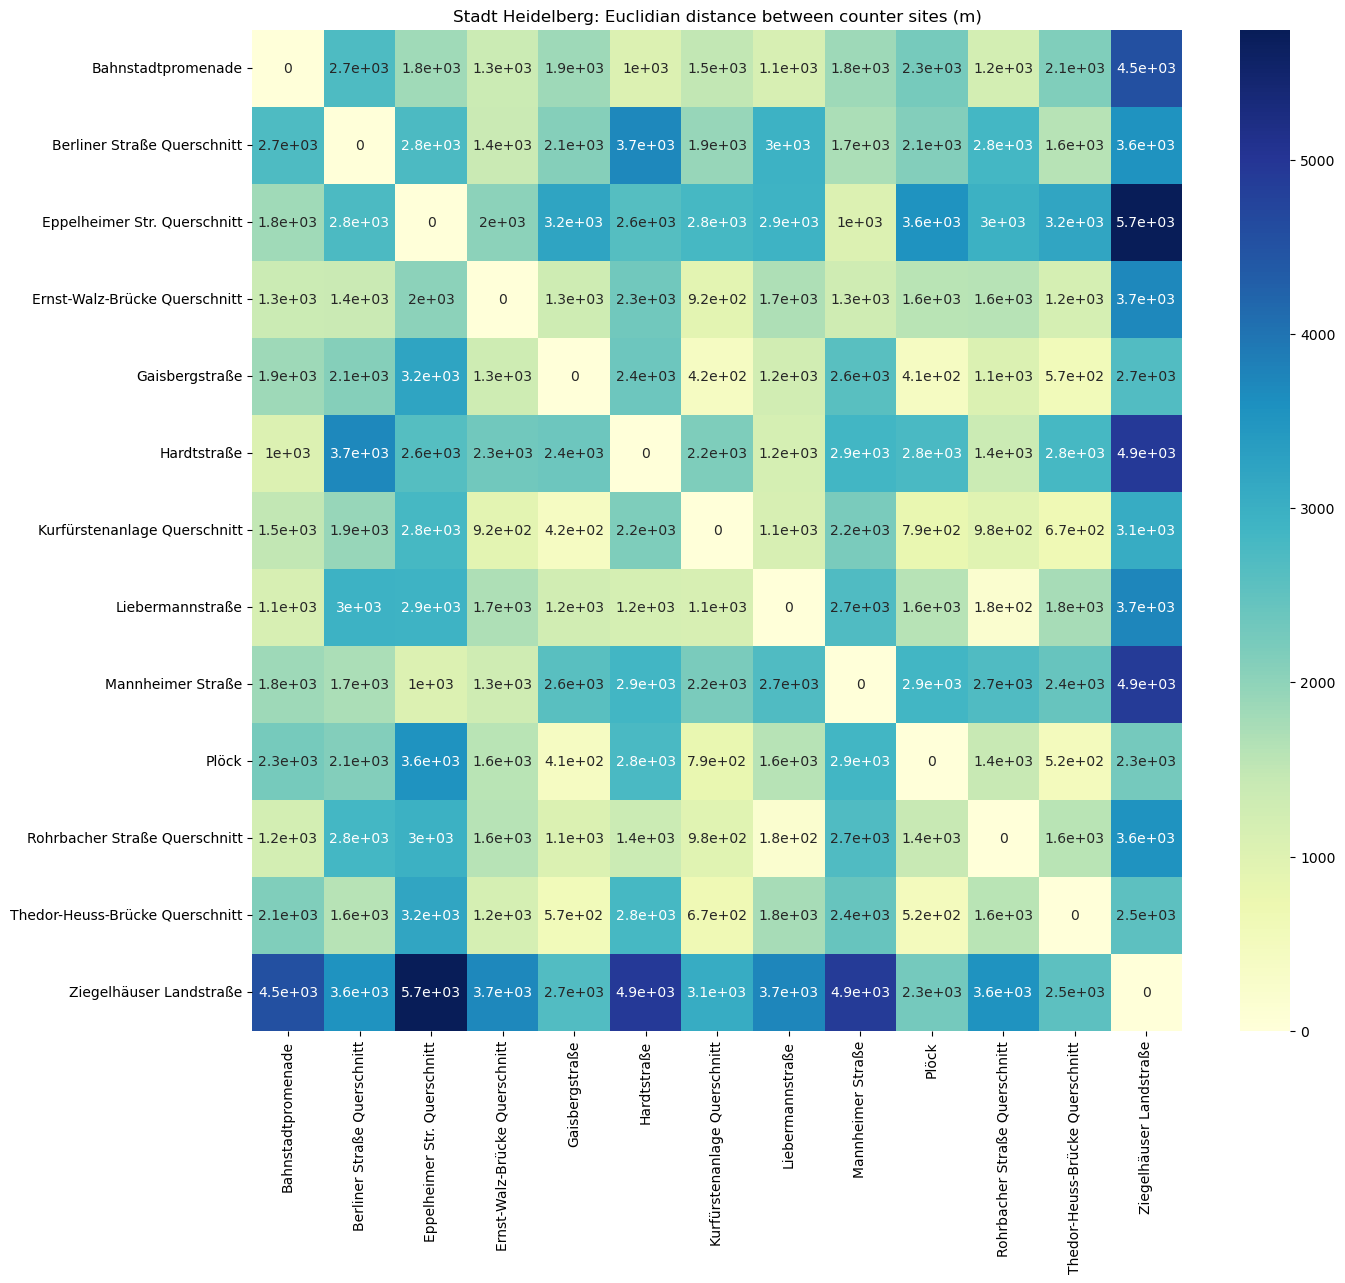

In [14]:
# now again for euclidian distances (we computed matrix already above)
plt.figure(figsize=(15,13))
sns.heatmap(dist_matrix_euclid.astype(float), annot=True, cmap='YlGnBu')
plt.title(f"{title_domain}: Euclidian distance between counter sites (m)")
plt.show()

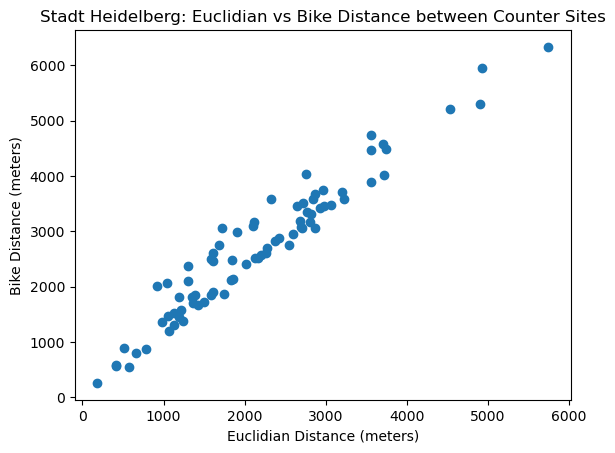

In [15]:
# euclidian vs bike distance scatter plot
euclidian_distances = []
bike_distances = []
for site_a in sites1:
    for site_b in sites1:
        if site_a >= site_b:
            continue
        euclidian_distances.append(dist_matrix_euclid.loc[site_a, site_b])
        bike_distances.append(dist_matrix.loc[site_a, site_b])
plt.scatter(euclidian_distances, bike_distances)
plt.xlabel("Euclidian Distance (meters)")
plt.ylabel("Bike Distance (meters)")
plt.title(f"{title_domain}: Euclidian vs Bike Distance between Counter Sites")
plt.show()

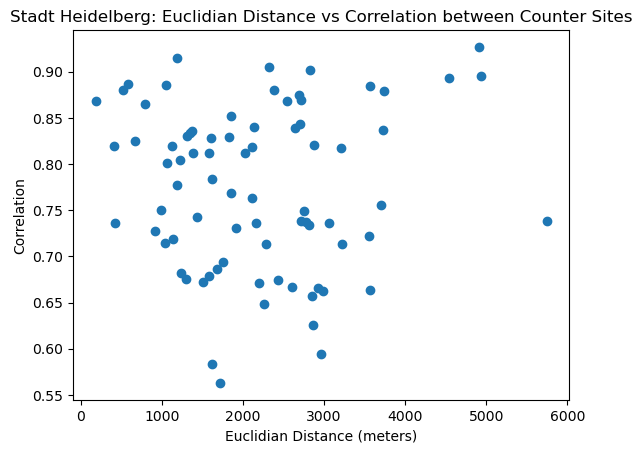

In [16]:
# euclidian distance vs correlation plot
# using euclidian distance and unaligned correlation
correlations = []
distance_values = []
for i in range(len(sites1)):
    for j in range(i + 1, len(sites1)):
        site1 = sites1[i]
        site2 = sites1[j]
        distance = dist_matrix_euclid.loc[site1, site2]
        correlation = corr_matrix.loc[site1, site2]
        distance_values.append(distance)
        correlations.append(correlation)

plt.scatter(distance_values, correlations)
plt.xlabel("Euclidian Distance (meters)")
plt.ylabel("Correlation")
plt.title(f"{title_domain}: Euclidian Distance vs Correlation between Counter Sites")
plt.show()

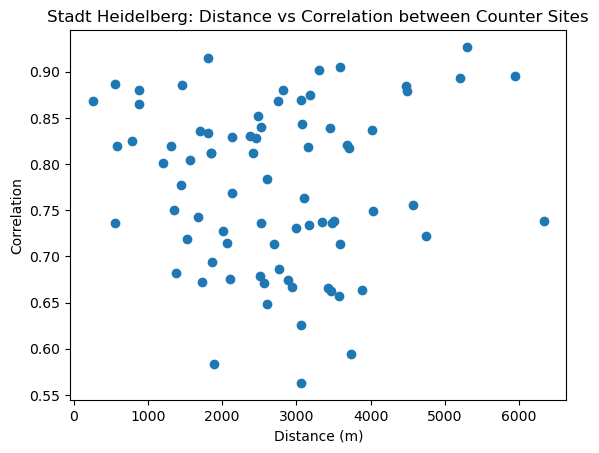

In [17]:
# distance vs correlation plot
# using bike distance and unaligned correlation
correlations = []
distance_values = []
for i in range(len(sites1)):
    for j in range(i + 1, len(sites1)):
        site1 = sites1[i]
        site2 = sites1[j]
        distance = dist_matrix.loc[site1, site2]
        correlation = corr_matrix.loc[site1, site2]
        distance_values.append(distance)
        correlations.append(correlation)


plt.scatter(distance_values, correlations)
plt.xlabel("Distance (m)")
plt.ylabel("Correlation")
plt.title(f"{title_domain}: Distance vs Correlation between Counter Sites")
plt.show()

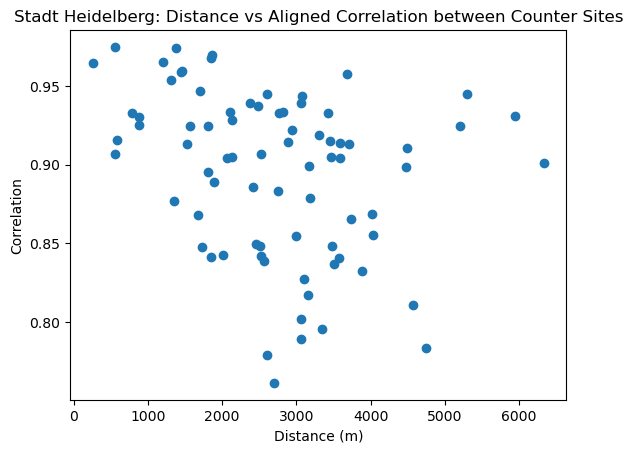

In [18]:
# distance vs correlation plot
# using bike distance and aligned correlation
correlations = []
distance_values = []
for i in range(len(sites1)):
    for j in range(i + 1, len(sites1)):
        site1 = sites1[i]
        site2 = sites1[j]
        distance = dist_matrix.loc[site1, site2]
        correlation = corr_matrix1.loc[site1, site2]
        distance_values.append(distance)
        correlations.append(correlation)


plt.scatter(distance_values, correlations)
plt.xlabel("Distance (m)")
plt.ylabel("Correlation")
plt.title(f"{title_domain}: Distance vs Aligned Correlation between Counter Sites")
plt.show()

In [19]:
################################################
# REGRESSION MODELING - SETUP                  #
################################################

import importlib
import regression_utils
importlib.reload(regression_utils)

from regression_utils import train_model

# Load city data with features
df_city = pd.read_csv('df_features.csv')
df_city = df_city[df_city['domain_name'] == title_domain].copy()

print(f"Loaded {len(df_city):,} hourly records for {title_domain}")
print(f"{df_city['counter_site'].nunique()} stations")
print(f"regression_utils.py reloaded")

Loaded 858,543 hourly records for Stadt Heidelberg
15 stations
regression_utils.py reloaded


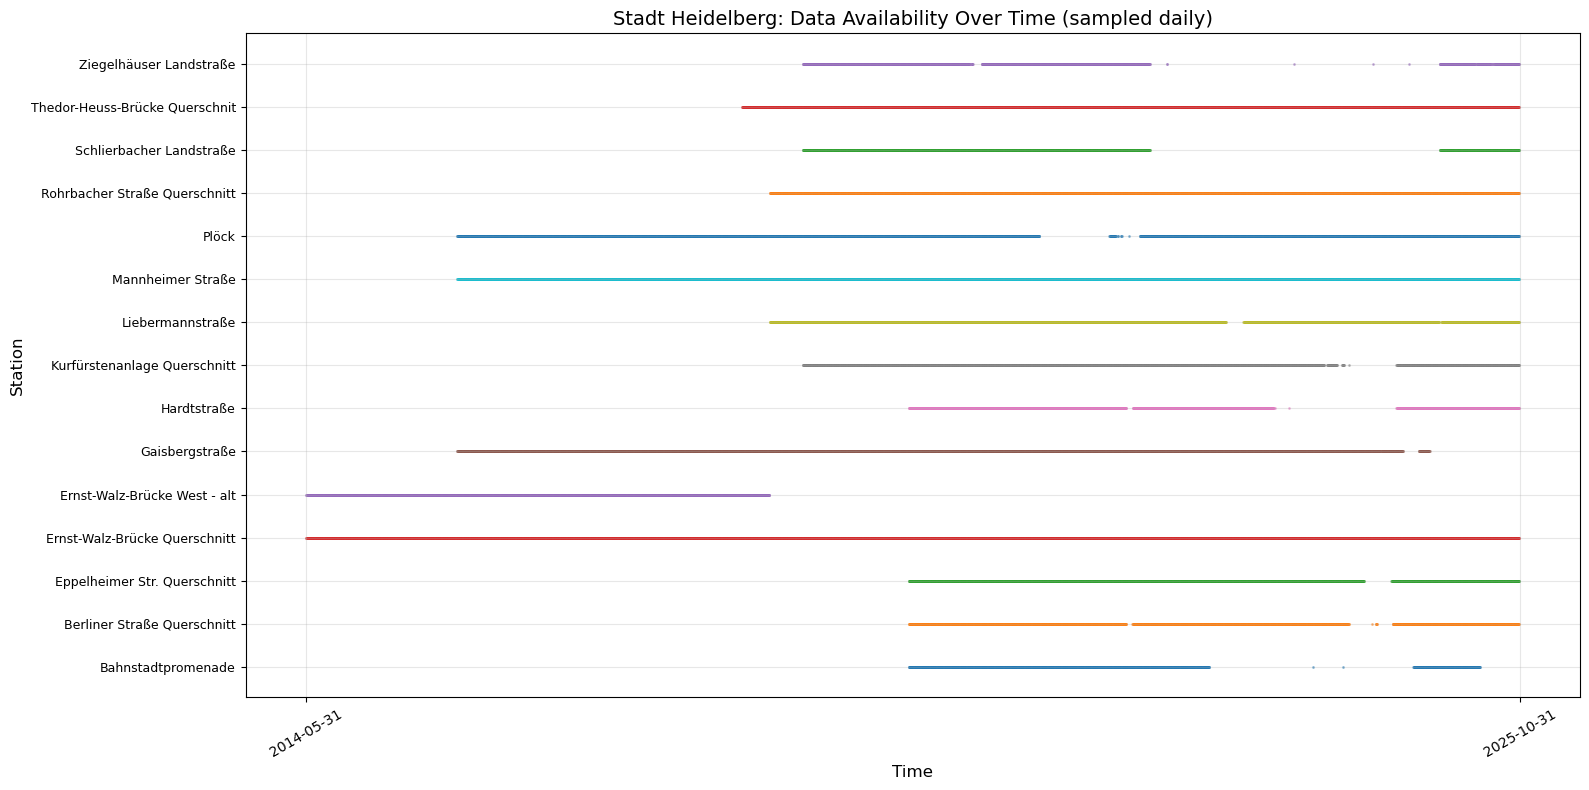


Data Availability Summary:
Total time range: 2014-05-31 22:00:00+00:00 to 2025-10-31 21:00:00+00:00
Total timestamps: 99,956

Timestamps with ALL stations: 0 (0.0%)

Per-station coverage:
  Bahnstadtpromenade                        30.4%
  Berliner Straße Querschnitt               46.4%
  Eppelheimer Str. Querschnitt              48.1%
  Ernst-Walz-Brücke Querschnitt            100.0%
  Ernst-Walz-Brücke West - alt              38.2%
  Gaisbergstraße                            78.8%
  Hardtstraße                               39.8%
  Kurfürstenanlage Querschnitt              54.2%
  Liebermannstraße                          60.2%
  Mannheimer Straße                         87.5%
  Plöck                                     80.0%
  Rohrbacher Straße Querschnitt             61.8%
  Schlierbacher Landstraße                  35.2%
  Thedor-Heuss-Brücke Querschnitt           64.1%
  Ziegelhäuser Landstraße                   34.3%

Sanity check:
Start window: 2014-05-31 22:00:00+00:00 → 2014

In [ ]:
################################################
# DATA AVAILABILITY VISUALIZATION              #
################################################

# Create pivot table to see when each station has data
df_pivot_avail = df_city.pivot_table(
    index='iso_timestamp',
    columns='counter_site',
    values='channels_all',
    aggfunc='count'
)

# Convert index to datetime to avoid categorical axis issues
df_pivot_avail.index = pd.to_datetime(df_pivot_avail.index)

# Convert to binary (1 = has data, 0 = missing)
df_avail_binary = df_pivot_avail.notna().astype(int)

# Sample data for visualization (every 24 hours to avoid overplotting)
df_sample = df_avail_binary.iloc[::24]

# Plot
fig, ax = plt.subplots(figsize=(16, 8))
ax.set_facecolor("white")
fig.patch.set_facecolor("white")

for i, station in enumerate(df_sample.columns):
    # Create line at y=i when data exists
    times = df_sample.index[df_sample[station] == 1]
    if len(times) > 0:
        ax.scatter(times, [i] * len(times), s=1, alpha=0.5)

# y-axis labels
ax.set_yticks(range(len(df_sample.columns)))
ax.set_yticklabels([s[:30] for s in df_sample.columns], fontsize=9)

# x-axis: ensure full time range is shown
start = df_avail_binary.index.min()
end = df_avail_binary.index.max()
#ax.set_xlim(start, end)

# Show start and end timestamps as tick labels
ax.set_xticks([start, end])
ax.set_xticklabels(
    [start.strftime("%Y-%m-%d"), end.strftime("%Y-%m-%d")],
    rotation=30
)

ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Station', fontsize=12)
ax.set_title(f'{title_domain}: Data Availability Over Time (sampled daily)', fontsize=14)
ax.grid(True, alpha=0.3)
plt.tight_layout()
# safe figure named after city 
# # in directory /plots
plt.savefig(os.join.path(PLOTS_DIR, 'distcorr/data_availability_{title_domain}.png'), dpi=300)
plt.show()

# Show statistics
print(f"\nData Availability Summary:")
print(f"Total time range: {df_avail_binary.index.min()} to {df_avail_binary.index.max()}")
print(f"Total timestamps: {len(df_avail_binary):,}")
print(f"\nTimestamps with ALL stations: {df_avail_binary.all(axis=1).sum():,} "
      f"({df_avail_binary.all(axis=1).sum()/len(df_avail_binary)*100:.1f}%)")
print(f"\nPer-station coverage:")
for station in df_avail_binary.columns:
    coverage = df_avail_binary[station].sum() / len(df_avail_binary) * 100
    print(f"  {station[:40]:40} {coverage:5.1f}%")

# --- Sanity check: first & last 7 days ---

# Full range
first_ts = df_avail_binary.index.min()
last_ts  = df_avail_binary.index.max()

# Window definitions
start_window_end = first_ts + pd.Timedelta(days=7)
end_window_start = last_ts  - pd.Timedelta(days=7)

start_window = df_avail_binary[(df_avail_binary.index >= first_ts) &
                               (df_avail_binary.index <= start_window_end)]

end_window = df_avail_binary[df_avail_binary.index >= end_window_start]

# Active if at least one "1" appears in that window
active_start = list(start_window.columns[start_window.sum(axis=0) > 0])
inactive_start = list(start_window.columns[start_window.sum(axis=0) == 0])

active_end = list(end_window.columns[end_window.sum(axis=0) > 0])
inactive_end = list(end_window.columns[end_window.sum(axis=0) == 0])

print("\nSanity check:")
print(f"Start window: {first_ts} → {start_window_end}")
print(f"  Active stations in first 7 days:   {len(active_start)}")
print(f"  Inactive stations in first 7 days: {len(inactive_start)}")

print(f"\nEnd window:   {end_window_start} → {last_ts}")
print(f"  Active stations in last 7 days:    {len(active_end)}")
print(f"  Inactive stations in last 7 days:  {len(inactive_end)}")



In [ ]:
################################################
# TRAIN MODELS FOR ALL STATIONS               #
################################################

all_results = []

for station_idx, station in enumerate(sites1, 1):
    print(f"\n[{station_idx}/{len(sites1)}] {station}")
    
    # Get station data
    df_station = df_city[df_city['counter_site'] == station].copy()
    df_station = df_station.dropna(subset=['channels_all'])
    df_station = df_station.sort_values('iso_timestamp')
    
    # Skip if insufficient data
    if len(df_station) < 1000:
        print(f"    ⊗ Skipped - only {len(df_station)} records")
        continue
    
    # Train model (prints data info internally)
    results, model, features = train_model(df_station, station, df_city)
    
    # Format feature names
    temporal_str = ', '.join(results['temporal_features'])
    weather_str = ', '.join(results['weather_features']) if results['weather_features'] else 'none'
    
    all_results.append(results)
    
    print(f"    Features: {temporal_str} + {weather_str} + {results['n_stations']} station counts = {results['n_features']} total")
    print(f"    Test R² = {results['test_r2']:.4f} | RMSE = {results['test_rmse']:.2f}")

# Create summary DataFrame
results_df = pd.DataFrame(all_results)

print(f"\n{'='*70}")
print(f"SUMMARY - {title_domain}")
print(f"{'='*70}")
print(f"\nAverage Test R²:   {results_df['test_r2'].mean():.4f} ± {results_df['test_r2'].std():.4f}")
print(f"Average Test RMSE: {results_df['test_rmse'].mean():.2f} ± {results_df['test_rmse'].std():.2f}")
print(f"Average Test MAE:  {results_df['test_mae'].mean():.2f} ± {results_df['test_mae'].std():.2f}")

# Print results as markdown table
print(f"\n## Results Table\n")
print("| Station | Test R² | RMSE | MAE | Features |")
print("|---------|---------|------|-----|----------|")
for _, row in results_df.iterrows():
    print(f"| {row['station'][:30]} | {row['test_r2']:.4f} | {row['test_rmse']:.2f} | {row['test_mae']:.2f} | {row['n_features']} |")

# Save results
results_df.to_csv(f'regression_results_{title_domain.replace(" ", "_")}.csv', index=False)
print(f"\n✓ Saved: regression_results_{title_domain.replace(' ', '_')}.csv")


[1/13] Bahnstadtpromenade
    Complete coverage: 0/99,956 hours (0.0%)
Shapes of: X_train, y_train, X_test, y_test
(0, 17) (0,) (0, 17) (0,)


ValueError: Found array with 0 sample(s) (shape=(0, 17)) while a minimum of 1 is required by LinearRegression.